In [1]:
%matplotlib notebook
from __future__ import division
from matplotlib.pyplot import plot, ylabel, xlabel, yscale, xscale, legend, subplots, gca
from matplotlib.ticker import FormatStrFormatter

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import numpy as np
import gzip
import cPickle
from scipy.optimize import minimize
from climin.util import optimizer
from itertools import repeat, cycle, islice, izip
inf = float("inf")

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [3]:
from breze.learn.data import one_hot
from breze.learn.base import cast_array_to_local_type
from schlichtanders.myfunctools import compose, meanmap, summap
from schlichtanders.mygenerators import eatN, chunk, every
from schlichtanders.myplot import add_val, add_point
from schlichtanders.mycontextmanagers import ignored

In [4]:
import theano
import theano_models as tm
import theano_models.deterministic_models as dm

# Data

In [5]:
datafile = '../data/mnist.pkl.gz'
# Load data.                                                                                                   

with gzip.open(datafile,'rb') as f:                                                                        
    train_set, val_set, test_set = cPickle.load(f)                                                       

X, Z = train_set                                                                                               
VX, VZ = val_set
TX, TZ = test_set

Z = one_hot(Z, 10)
VZ = one_hot(VZ, 10)
TZ = one_hot(TZ, 10)

image_dims = 28, 28

X, Z, VX, VZ, TX, TZ = [cast_array_to_local_type(i) for i in (X, Z, VX,VZ, TX, TZ)]
map(np.shape, [X, Z, VX, VZ, TX, TZ])

[(50000, 784),
 (50000, 10),
 (10000, 784),
 (10000, 10),
 (10000, 784),
 (10000, 10)]

# Model

In [6]:
model = dm.Mlp(input=X[0], output_size=10, output_transfer="softmax", hidden_sizes=[200]*2, hidden_transfers=["rectifier"]*2)
model

Mlp { 'inputs': [TensorConstant{[ 0.      ...        ]}],
  'outputs': AffineNonlinear3.outputs,
  'parameters': [ AffineNonlinear.weights,
                  AffineNonlinear.bias,
                  AffineNonlinear2.weights,
                  AffineNonlinear2.bias,
                  AffineNonlinear3.weights,
                  AffineNonlinear3.bias]}

# Optimizer

In [7]:
flat = tm.prox_flatten(model['parameters'])
loss = tm.loss_deterministic(model)
optimizer_kwargs = tm.numericalize(loss, flat, 
    batch_mapreduce=meanmap,
    adapt_init_params=lambda ps: ps + np.random.normal(size=ps.size) * 0.01,
)

Climin wants an iterators of (args, kwarsg) as keyword argument "args" (to be passed to the loss function). Concretley, we use an infinite iterator over minibatches.

In [8]:
batch_size = 30
n_whole_data = X.shape[0] // batch_size
climin_args = izip(izip(chunk(batch_size, cycle(Z)), chunk(batch_size, cycle(X))), repeat({}))

In [9]:
opt = optimizer(
    identifier = "adadelta",
    args=climin_args, # repeat(((Z,X),{})),
    **tm.climin_kwargs(optimizer_kwargs)
)

batch_precompile
batch_precompile


/home/stephan/GitProjects/climin/climin/util.py:151: UserWarning: Argument named f is not expected by <class 'climin.adadelta.Adadelta'>
  % (i, klass))


# Visualized Fit

In [10]:
val_size = batch_size

<IPython.core.display.Javascript object>


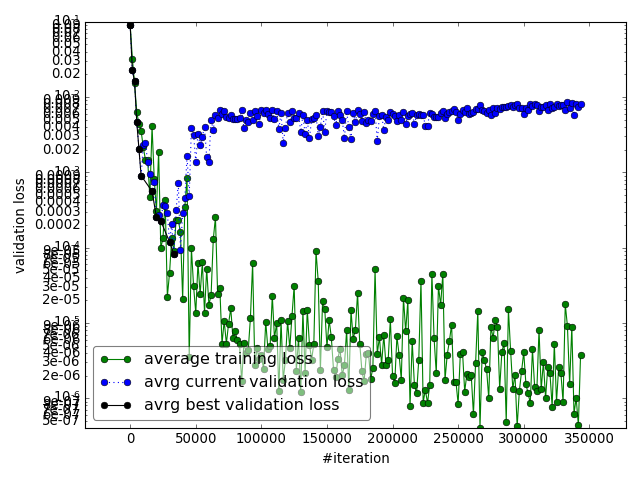

In [11]:
line_train, = plot([], [], 'go-', label="average training loss")
line_curr_val, = plot([],[], 'bo:', label="avrg current validation loss")
line_best_val, = plot([], [], 'ko-', label="avrg best validation loss")

best_wrt = None
best_val_loss = optimizer_kwargs['num_loss'](opt.wrt, VZ[:val_size], VX[:val_size])
training_loss = optimizer_kwargs['num_loss'](opt.wrt, Z[:val_size], X[:val_size])
add_point(line_curr_val, opt.n_iter, best_val_loss)
add_point(line_best_val, opt.n_iter, best_val_loss)
add_point(line_train, opt.n_iter, training_loss)

# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
yscale('log')
gca().yaxis.set_minor_formatter(FormatStrFormatter("%.2g"))
ylabel("validation loss")
xlabel("#iteration")
legend(loc='lower left', fancybox=True, framealpha=0.5)

In [12]:
with ignored(KeyboardInterrupt):
    for info in every(n_whole_data, opt):
        # collect and visualize validation loss for choosing the best model
        val_loss = optimizer_kwargs['num_loss'](opt.wrt, VZ[:val_size], VX[:val_size])
        if val_loss < best_val_loss:
            best_wrt = opt.wrt
            best_val_loss = val_loss
            add_point(line_best_val, opt.n_iter, val_loss)
        add_point(line_curr_val, opt.n_iter, val_loss)

        # visualize training loss for comparison:
        training_loss = optimizer_kwargs['num_loss'](opt.wrt, Z[:val_size], X[:val_size])
        add_point(line_train, opt.n_iter, training_loss)

# Performance

In [13]:
predict = theano.function([flat]+model['inputs'], model['outputs'])
def best_predict(x):
    return predict(best_wrt, x)
best_predict(X[0]), Z[0]

(array([  1.23985611e-12,   7.54271065e-13,   2.93280003e-12,
          2.89769924e-03,   5.01026693e-26,   9.97102301e-01,
          8.76694633e-17,   9.52741126e-18,   1.12962500e-13,
          6.21616034e-11]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]))

In [14]:
PX = np.apply_along_axis(best_predict, 1, X)
PVX = np.apply_along_axis(best_predict, 1, VX)
PTX = np.apply_along_axis(best_predict, 1, TX)

In [15]:
print 'error rate train/val/test:  %g/%g/%g' % (
    (PX[:, :10].argmax(1) != Z.argmax(1)).mean(),
    (PVX[:, :10].argmax(1) != VZ.argmax(1)).mean(),
    (PTX[:, :10].argmax(1) != TZ.argmax(1)).mean())

error rate train/val/test:  0.00158/0.0208/0.0202
